# K2 C05 M67 lightcurve search

In [1]:
import lightkurve

In [2]:
lightkurve.__version__

'1.0b26.dev'

In [3]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The M67 data is stored as 50 x 50 pixel blocks.  There's apparently no way to figure out which source is in which block!  Whyyyy?   
Let's just manually reverse engineer the pointing.


We'll first identify the list of Custom Aperture IDs that targeted M67.  These Custom Aperture IDs resemble per-target EPIC ids, except that their first three numbers are less than 201.  We can retrieve this list from the K2 website.

We'll then identify a way to derive the cone of sky that each 50 x 50 block observed.

In [4]:
df_targs = pd.read_csv('https://keplerscience.arc.nasa.gov/data/campaigns/c5/K2Campaign5targets.csv')

In [5]:
df_targs.columns

Index(['EPIC ID', ' RA (J2000) [deg]', ' Dec (J2000) [deg]', ' magnitude',
       ' Investigation IDs'],
      dtype='object')

In [6]:
M67_ids = df_targs[' Investigation IDs'].str.contains('M67')

In [7]:
M67_ids.sum()

72

In [8]:
df_M67 = df_targs[M67_ids].reset_index(drop=True)

In [9]:
df_M67.tail()

,EPIC ID,RA (J2000) [deg],Dec (J2000) [deg],magnitude,Investigation IDs
67,200008711,,,,LC_M67_TILE|GO5031_LC
68,200008712,,,,LC_M67_TILE|GO5031_LC
69,200008713,,,,LC_M67_TILE|GO5031_LC
70,200008714,,,,LC_M67_TILE|GO5031_LC
71,200008715,,,,LC_M67_TILE|GO5031_LC


In [10]:
df_M67['EPIC ID'].values[-5:]

array([200008711, 200008712, 200008713, 200008714, 200008715])

In [11]:
tpf = lightkurve.KeplerTargetPixelFile.from_archive(200008715)

/Users/obsidian/GitHub/lightkurve/lightkurve/targetpixelfile.py:740: LightkurveWarning: `TargetPixelFile.from_archive` is deprecated and will be removed soon, please use `lightkurve.search_targetpixelfile()` instead.
  LightkurveWarning)


In [12]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [13]:
tpf.ra, tpf.dec

(132.985857, 11.635697)

In [14]:
c = SkyCoord(ra='08 51 13.354', dec='+11 51 40.15', unit=(u.hourangle, u.deg), frame='icrs')

In [15]:
def target_in_WCS(tpf, sky_coord):
    '''Check if target is inside a tpf boundary'''
    n_cad, tpf_x, tpf_y = tpf.shape
    xx, yy = tpf.wcs.all_world2pix(sky_coord.ra, sky_coord.dec, 0)
    in_mask = ( (xx > 0 ) & (xx < tpf_x) & (yy > 0 ) & (yy < tpf_y) )
    return in_mask

In [16]:
from tqdm import tqdm as tqdm

The first time running this takes a while-- you have to query MAST and download files.

In [17]:
import glob

In [18]:
for epic_id in tqdm(df_M67['EPIC ID'].values):
    search_string = '/Users/obsidian/.lightkurve-cache/mastDownload/K2/*{}*/*'
    fn = glob.glob(search_string.format(epic_id))[0]
    #print(fn)
    #tpf = lightkurve.KeplerTargetPixelFile(fn)  #This should work!
    

100%|██████████| 72/72 [00:00<00:00, 243.35it/s]


In [19]:
#! ls mastDownload/K2/ktwo20000*

Once you've already queried MAST and have the files locally...

In [20]:
df_M67['fn'] = df_M67['EPIC ID'].apply(lambda x:"ktwo{}-c05_lc/ktwo{}-c05_lpd-targ.fits.gz".format(x,x))

```python
hit_list = []

for epic_id in tqdm(df_M67['EPIC ID'].values):
    fn = glob.glob(search_string.format(epic_id))[0]
    try:
        tpf = lightkurve.KeplerTargetPixelFile(fn)
        hit = target_in_WCS(tpf, c)
        hit_list.append(hit)
    except:
        print(fn)
        
np.array(hit_list).sum()
```

Yay!!  There's one Target Pixel File with our target-of-interest inside its boundaries!

In [21]:
#df_M67[hit_list]

In [22]:
#! ls /Users/obsidian/.lightkurve-cache/mastDownload/K2/

In [23]:
tpf = lightkurve.KeplerTargetPixelFile('/Users/obsidian/.lightkurve-cache/mastDownload/K2/'+df_M67.fn[30])

In [24]:
ncad, dx, dy = tpf.shape

In [25]:
tpf.row, tpf.column, ncad, dx, dy

(337, 951, 3450, 50, 50)

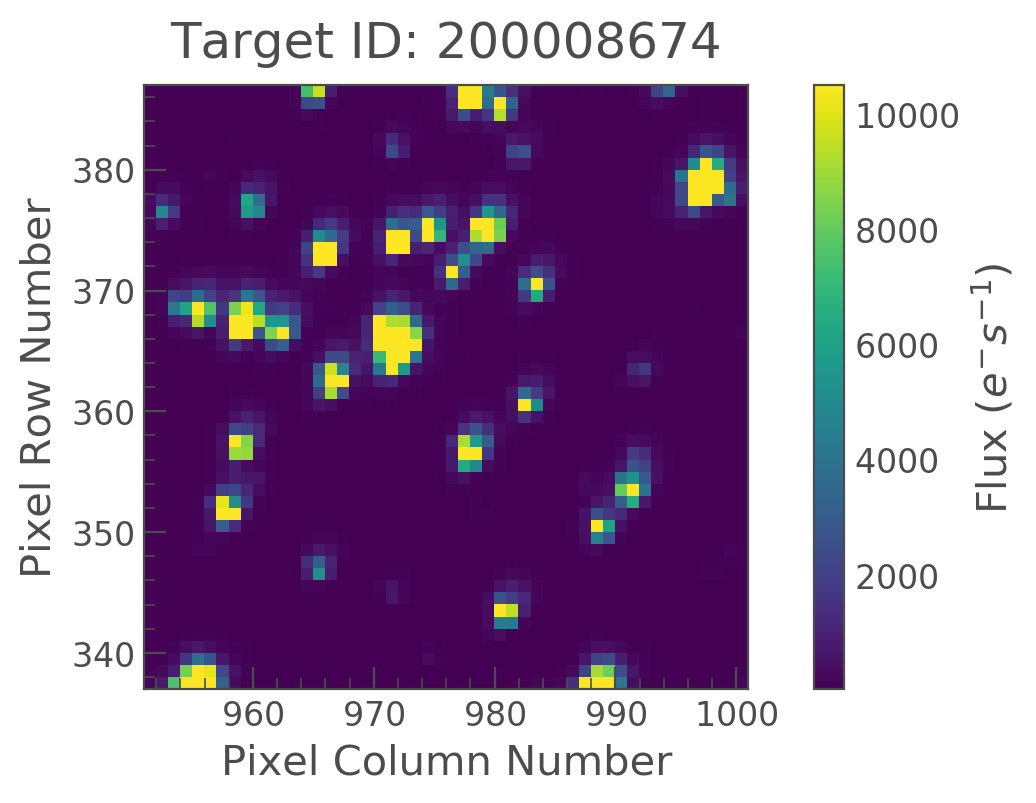

In [26]:
tpf.plot();

Oh no, which source is it??

In [27]:
delta_y, delta_x = tpf.wcs.all_world2pix(c.ra.value, c.dec.value, 1)
tpf.row + delta_x, tpf.column + delta_y

(352.49144132556603, 958.4063612490943)

It's in entirely within the TPF boundary!  Great!

In [28]:
#tpf.interact()

In [29]:
! ls *.fits

ktwo200008674-c05_lpd-targ-custom-lc.fits
ktwo200233338-c18_lpd-targ-custom-lc.fits


In [30]:
from astropy.io import fits

In [31]:
custom_mask = fits.open('ktwo200008674-c05_lpd-targ-custom-lc.fits')['APERTURE'].data

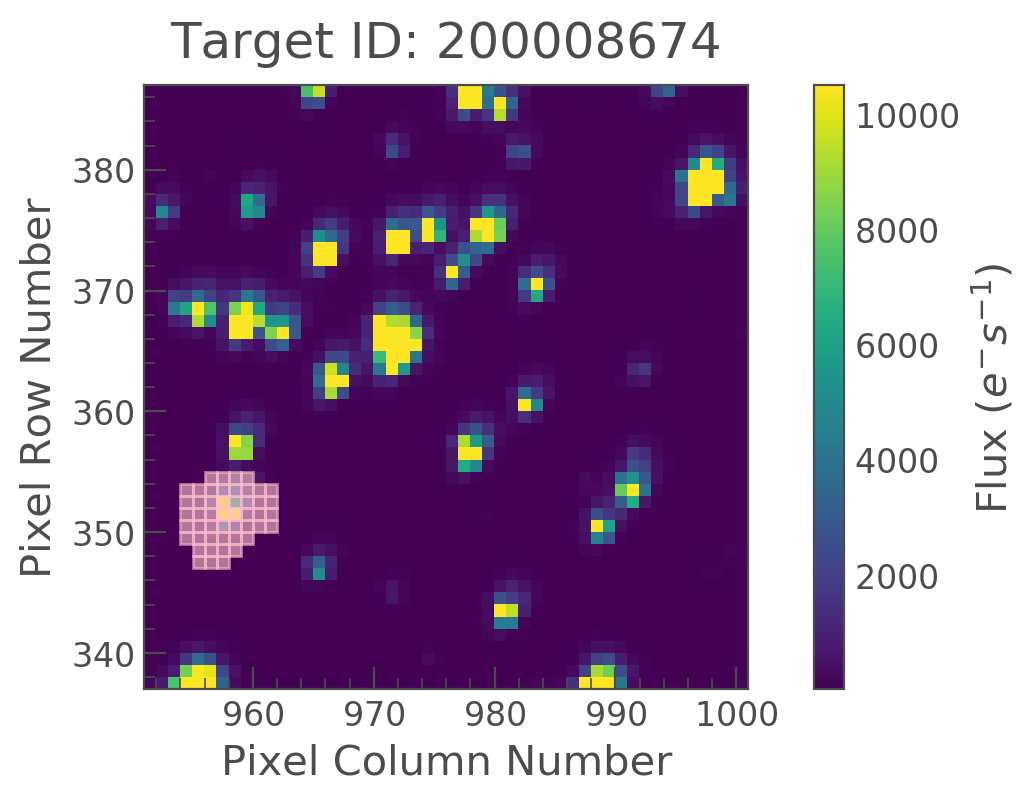

In [32]:
tpf.plot(aperture_mask=custom_mask)

In [33]:
lc_targ = tpf.extract_aperture_photometry(aperture_mask=custom_mask)

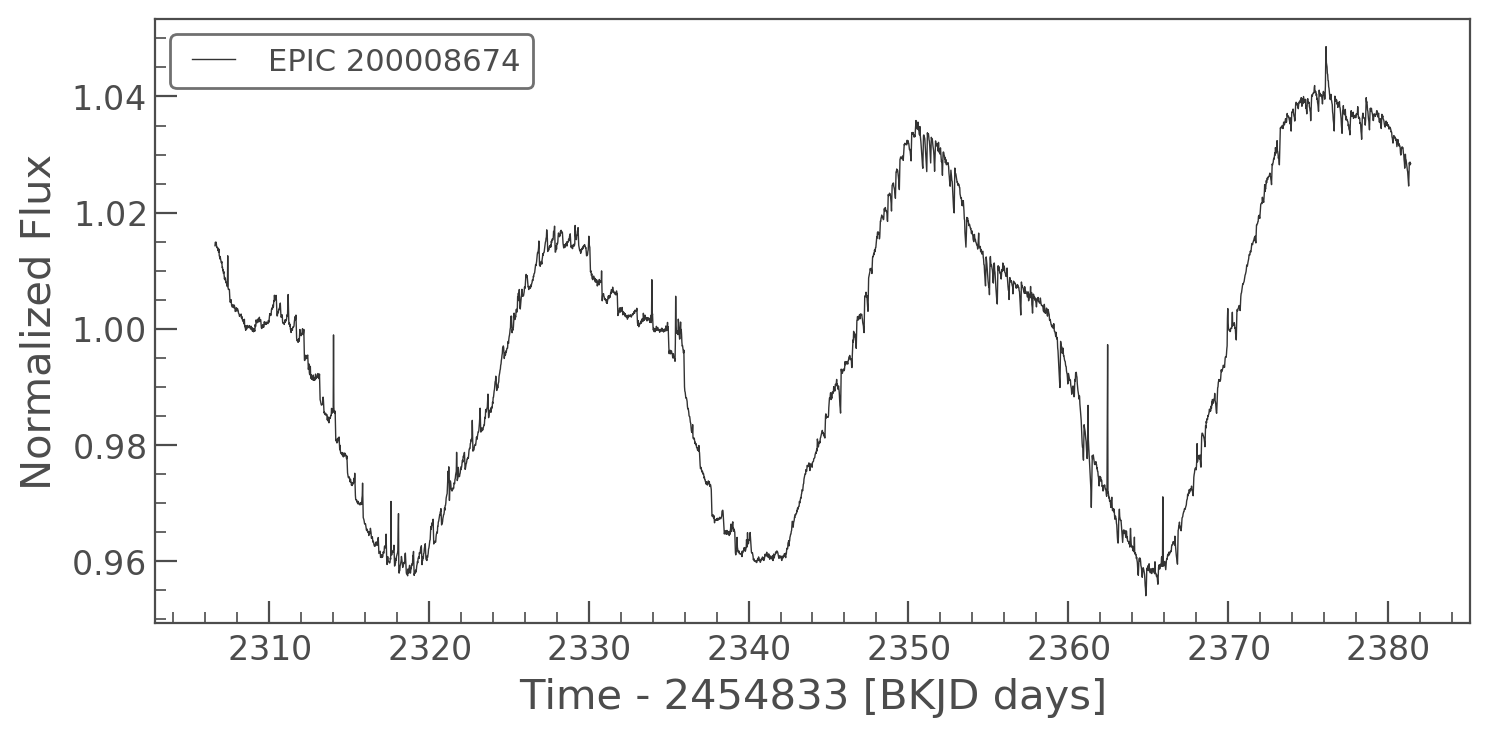

In [34]:
lc_targ.plot()

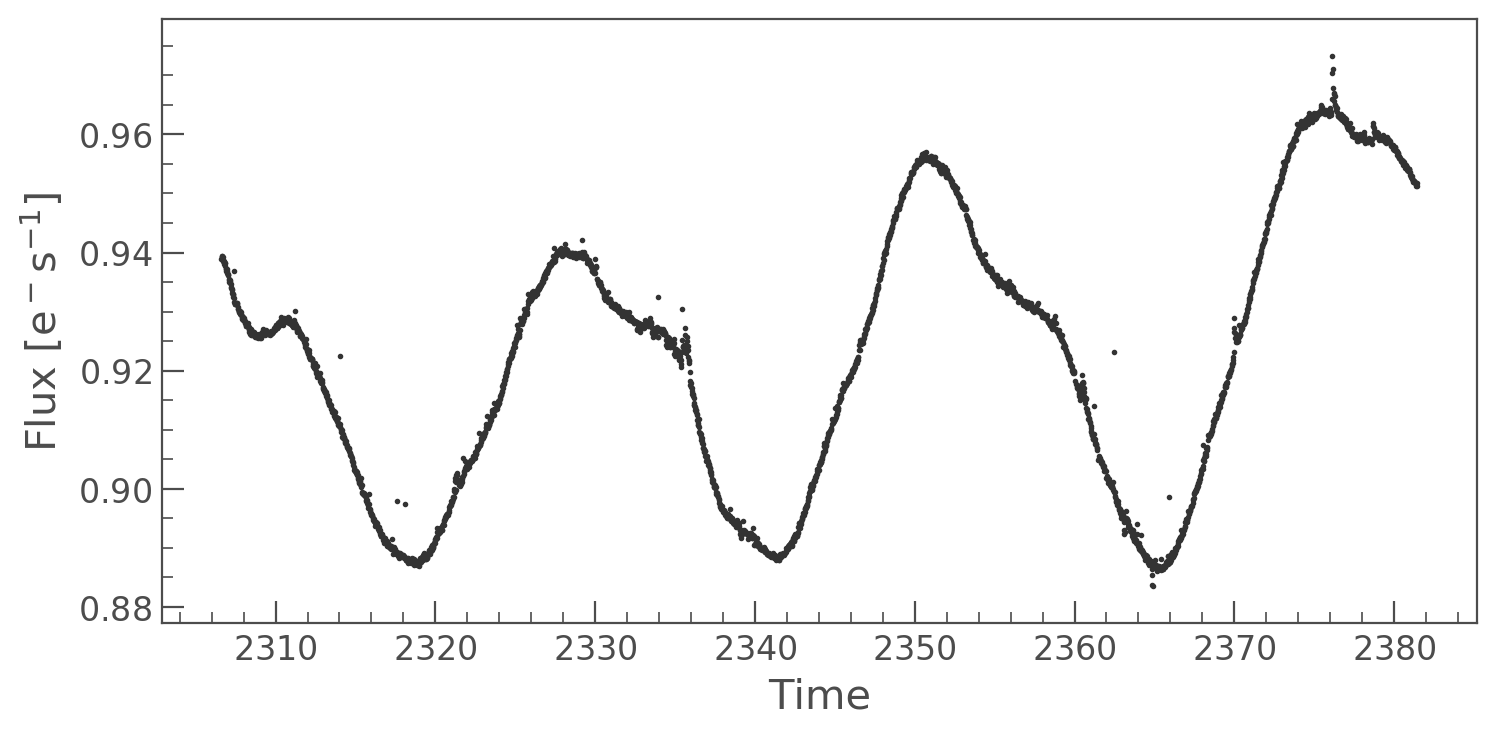

In [35]:
from lightkurve.correctors import SFFCorrector

sff = SFFCorrector()

lc_corrected = sff.correct(lc_targ.time, lc_targ.flux, 
                           lc_targ.centroid_col, lc_targ.centroid_row,
                           niters=5, windows=20, polyorder=5, restore_trend=True)

(lc_corrected.normalize()/1.08).scatter(normalize=False)

(2, 80)

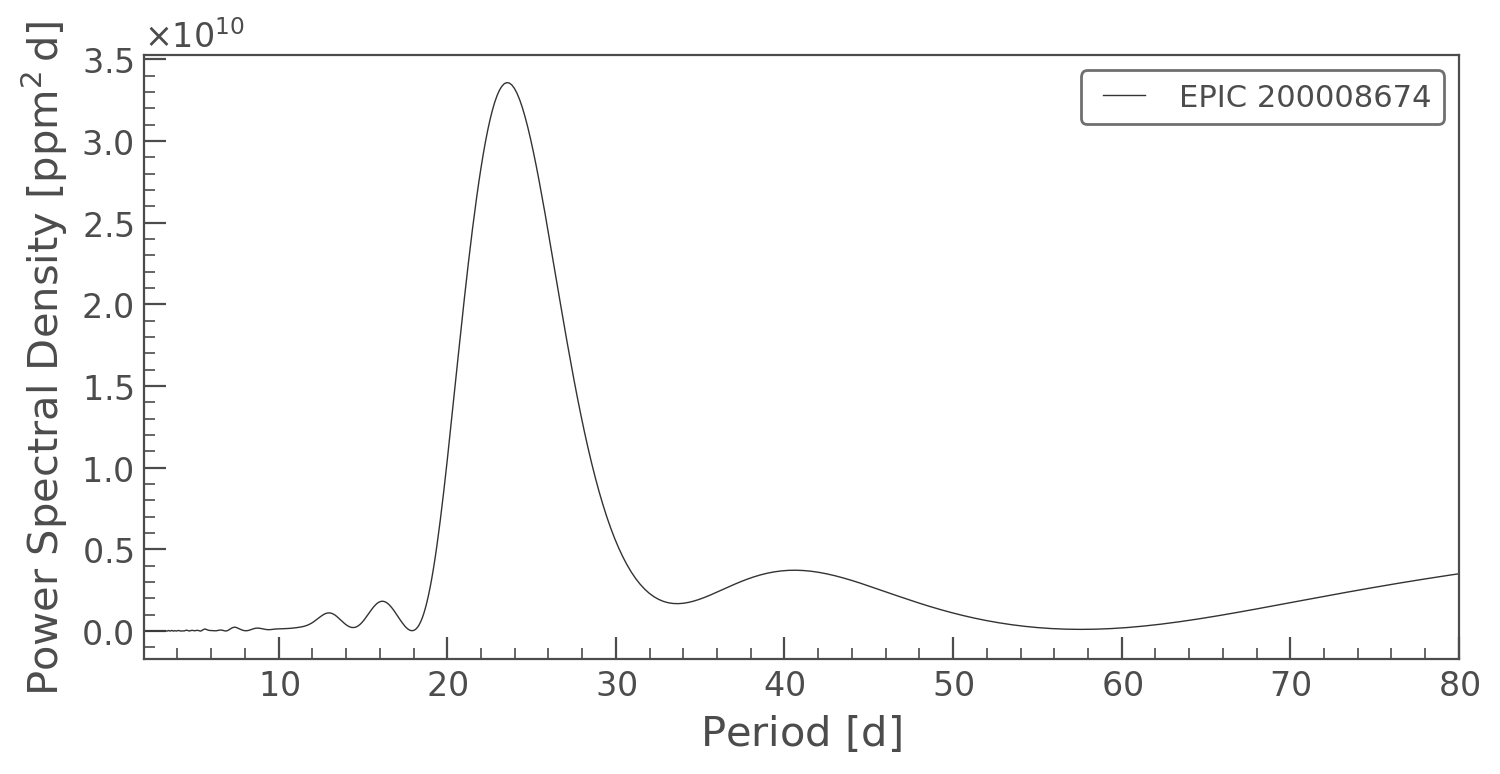

In [36]:
pg = lc_targ.to_periodogram(oversample_factor=50)
pg.plot(format='period')
plt.xlim(2, 80)

In [37]:
pg.period_at_max_power

<Quantity 23.52868818 d>

In [38]:
df_out = lc_corrected.to_pandas()

In [39]:
df_out = df_out.reset_index(drop=True)[['time', 'flux']]
df_out.head()

,time,flux
0,2306.611034,75448.696167
1,2306.631467,75493.547790
2,2306.651899,75484.010204
3,2306.672331,75494.105763
4,2306.692763,75473.021009


In [47]:
#! mkdir ../data/K2

In [48]:
df_out.to_csv('../data/K2/S1063_K2_C05_lightkurve_SFF.csv', index=False)

In [41]:
! ls -1 *.csv

S1063_K2_C05_lightkurve_SFF.csv
S1063_K2_C16_lightkurve_SFF.csv
S1063_K2_C18_lightkurve_SFF.csv
